### A Notebook to showcase release 0.12.0: use of `segment`, `apply_ragged`, `prune`, `chunk`, and `velocity_from_position` functions

1. Example of segment to calculate velocity
2. Example of chunks to calculate the Latitude-Frequency spectra

In [1]:
import clouddrift as cd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime

In [3]:
from clouddrift.analysis import segment,chunk, velocity_from_position, prune, apply_ragged

In [4]:
#url_path = 'https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/latest/'
#url_path = 'https://noaa-oar-hourly-gdp-pds.s3.us-east-1.amazonaws.com/latest/'
#file = 'gdp_v2.00.nc'
#ds = xr.open_dataset(url_path+file+'#mode=bytes')
file = '/Users/selipot/Data/awss3/latest/gdp_v2.00.nc'
#ds = xr.open_dataset(file,engine='netcdf4',decode_times=False) # undecoded time is seconds since 1970-01-01 00:00:00
ds = xr.open_dataset(file,engine='netcdf4',decode_times=True) # we should use this once we solve the prune issue
ds

<xarray.Dataset>
Dimensions:                (traj: 17324, obs: 165754333)
Coordinates:
    ids                    (obs) int64 ...
    time                   (obs) datetime64[ns] ...
    lon                    (obs) float32 ...
    lat                    (obs) float32 ...
Dimensions without coordinates: traj, obs
Data variables: (12/55)
    ID                     (traj) int64 ...
    rowsize                (traj) int32 ...
    WMO                    (traj) int32 ...
    expno                  (traj) int32 ...
    deploy_date            (traj) datetime64[ns] ...
    deploy_lat             (traj) float64 ...
    ...                     ...
    err_sst1               (obs) float64 ...
    err_sst2               (obs) float64 ...
    flg_sst                (obs) int8 ...
    flg_sst1               (obs) int8 ...
    flg_sst2               (obs) int8 ...
    drogue_status          (obs) bool ...
Attributes: (12/16)
    title:             Global Drifter Program hourly drifting buoy collection
    history:           Version 2.00.  Metadata from dirall.dat and deplog.dat
    Conventions:       CF-1.6
    date_created:      2022-12-09T06:02:29.684949
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    summary:           Global Drifter Program hourly data
    doi:               10.25921/x46c-3620

Some explanation about the ragged array representation of the data and how the GDP data are organized. In order to access the data for one given trajectory, one needs to build a trajectory index. This is conveniently done from the `rowsize` variable that indicates the number of rows in the ragged array for each trajectory. (Otherwise we can calculate the rowsize by applying segment on the ids variable).

In [5]:
# create a trajectory index
traj_idx = np.insert(np.cumsum(ds.rowsize.values), 0, 0)

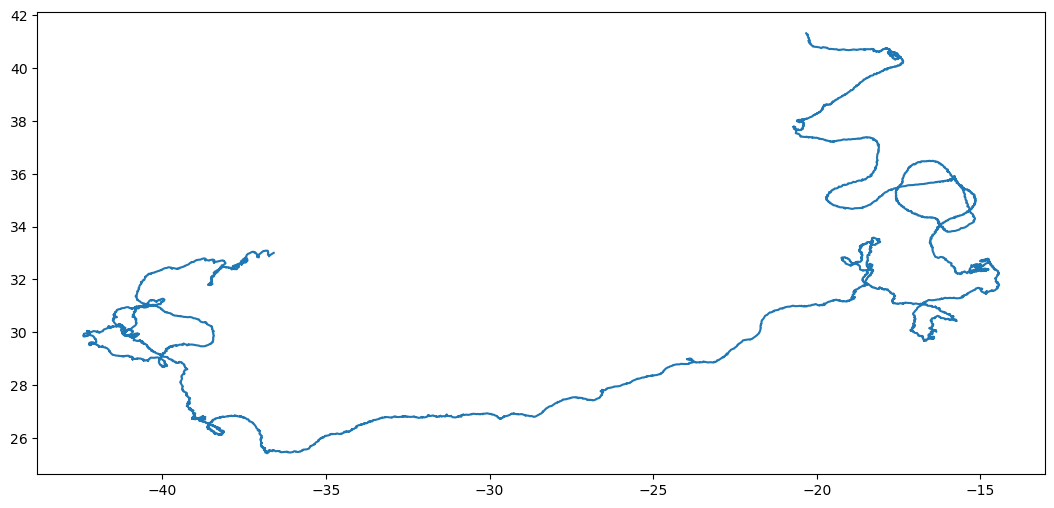

In [6]:
# here for example we examine row number 100 of the ragged arrays and display latitude vs longitude
j = 100
row = slice(traj_idx[j], traj_idx[j+1])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
ax.plot(ds.lon[row],ds.lat[row])

In [8]:
# the trajectory appears contiguous but actually it has time intervals larger than strictly one hour (say something about how the dataset is organized)
# diff_time1 = np.diff(ds.time[row])
# diff_time2 = np.diff(ds2.time[row])
# display(diff_time1.dtype)
# display(diff_time2.dtype)

In [9]:
#diff_time1.dtype is np.dtype(np.float64)

In [10]:
#diff_time2.dtype is np.dtype('<m8[ns]')

In [11]:
# if type(diff_time) is np.ndarray:
#     q = np.where(diff_time>3600)
# elif type(diff_time) is 

In [14]:
diff_time = np.diff(ds.time[row])
q = np.where(diff_time>np.timedelta64(3600, 's'))
display(diff_time[q]/(3600*1e9))

array([14, 37, 15], dtype='timedelta64[ns]')

Therefore, we want to cut or divide up or segment the individual trajectories whenever the time step is larger than one hour. We do this because eventually want to apply time series/spectral analyses that require evenly sampled time series.

In [15]:
# we define the tolerance for segmenting trajectories, here one hour or 3600 s
dt = np.timedelta64(3600, 's') # timedelta(seconds=1800)
# we apply the segment function that returns the length of each contiguous segment of the trajectory selected (row)
row1 = segment(ds.time[row],tolerance=dt,rowsize=np.array([17874]))
row1

array([17833,    30,     5,     6])

We see above that the trajectory selected (row) is comprised of 4 segments of length 17833, 30, 5, and 6:

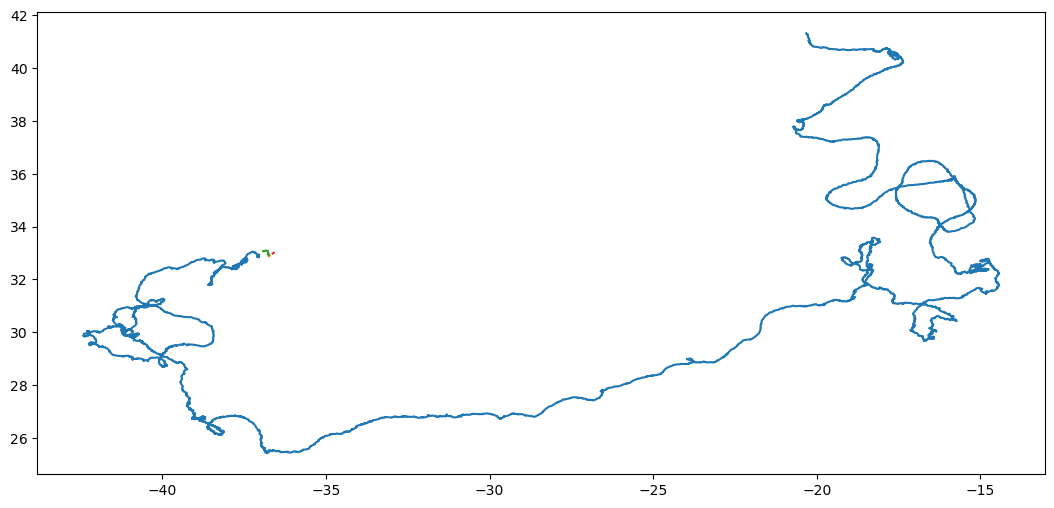

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
apply_ragged(ax.plot,[ds.lon[row],ds.lat[row]],row1);

We now apply the segmentation above but to all the individual trajectories of the ragged array. One optional argument of the `segment` function is the rowsize which makes it aware of existing rows in the ragged array. This makes sense, we want to segment individual trajectories by looking for temporal gaps within a single trajectory.

In [17]:
newrowsize = segment(ds.time,dt,rowsize=ds.rowsize)

In [18]:
display(np.shape(newrowsize)) # should be 88933
display(np.shape(ds.ID))

(88933,)

(17324,)

This results show that the GDP version 2.00 contains 88933 contiguous hourly segments (from 17324 drifters/trajectories). By the way, if your ragged array dataset came with no rowsize variable but a variable repeating identification numbers (ids) for each step you could also create the rowsize by using the function segment twice, in case the order of the ids is not monotonically increasing, i.e:

In [19]:
#newrowsize = segment(ds.time,tolerance=dt)
#newrowsize = segment(ds.time, dt, rowsize=segment(ds.time, -dt,rowsize=ds.rowsize))
rowsize1 = segment(ds.ids,0.5,rowsize=segment(ds.ids,-0.5))

# verify that the calculated rowsize is what came with the dataset
display(np.shape(rowsize1))
display(np.all(ds.rowsize.to_numpy()==rowsize1))

(17324,)

True

However, some segments are only of length one.

In [20]:
display(np.sum(newrowsize==1))

1130

Next, we want to illustrate the use of operations per segments, such as calculating velocity from successive positions. This requires a segment to be at least of length 2. As a result we first need to remove the length-1 segments. To calculate velocity from positions we will need the time, latitude, longitude. We also consider the original veloclity component estimates from the dataset for comparisons.

In [22]:
time,rowsize2 = prune(ds.time,newrowsize,min_rowsize=2)

In [25]:
lon, _ = prune(ds.lon,newrowsize,min_rowsize=2)
lat, _ = prune(ds.lat,newrowsize,min_rowsize=2)
ve, _ = prune(ds.ve,newrowsize,min_rowsize=2)
vn, _  = prune(ds.vn,newrowsize,min_rowsize=2)

In [39]:
display(np.shape(time))
display(np.shape(rowsize2))


(165753203,)

(87803,)

We can now use apply_ragged to calculate velocity for each one of the resulting 87803 contiguous segment, totaling now 165753203 data points

In [27]:
u,v = apply_ragged(velocity_from_position,[lon,lat,time],rowsize2,coord_system='spherical')

We now can compare this simple forward difference velocity estimate to the one from the dataset

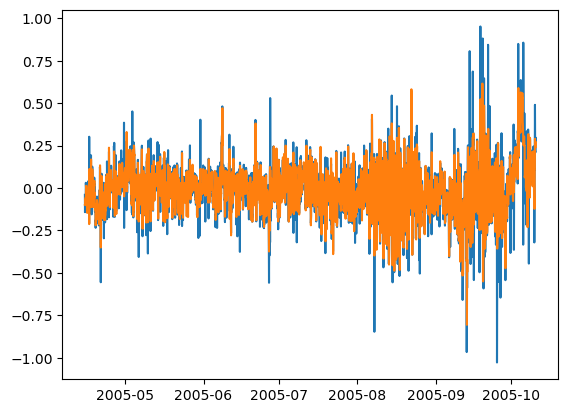

In [38]:
traj_idx2 = np.insert(np.cumsum(rowsize2), 0, 0)
#j = len(rowsize2)
j = 1
row = slice(traj_idx2[j],traj_idx2[j+1])
plt.plot(time[row],u[row]*1e9) # multiply to get in meter per seconds
plt.plot(time[row],ve[row])

We now want to use the velocity data to estimate the average spectrum of oceanic velocity, which can be interpreted as decomposing kinetic energy as a function of frequency. For this we need to calculate a spectral estimate for a number of fixed-length segments, or chunks, of velocity time series. The clouddrift library provide a tool, `chunk` to split up row of various lengths in equal-size chunks.

In [40]:
chunk?

Signature:
chunk(
    x: Union[list, numpy.ndarray, xarray.core.dataarray.DataArray, pandas.core.series.Series],
    length: int,
    overlap: int = 0,
    align: str = 'start',
) -> numpy.ndarray
Docstring:
Divide an array ``x`` into equal chunks of length ``length``. The result
is a 2-dimensional NumPy array of shape ``(num_chunks, length)``. The resulting
number of chunks is determined based on the length of ``x``, ``length``,
and ``overlap``.

``chunk`` can be combined with :func:`apply_ragged` in order to chunk a ragged
array.

Parameters
----------
x : list or array-like
    Array to divide into chunks.
length : int
    The length of each chunk.
overlap : int, optional
    The number of overlapping array elements across chunks. The default is 0.
    Must be smaller than ``length``. For example, if ``length`` is 4 and
    ``overlap`` is 2, the chunks of ``[0, 1, 2, 3, 4, 5]`` will be
    ``np.array([[0, 1, 2, 3], [2, 3, 4, 5]])``. Negative overlap can be used
    to offset chunks 

In [43]:
N = 60*24
u60 = chunk(u,N,overlap=0,align='middle')
v60 = chunk(v,N,overlap=0,align='middle')

In [46]:
display(np.shape(u60))

(115106, 1440)

Now we can calculate the spectral estimates with a simple periodogram as an example [modify to use a taper perhaps].  

In [ ]:
# form the complex velocity
z = (u60+1j*v60)*1e9 # in m/s
# form a normalized boxcar window
foo = np.ones(z.shape[1]); 
boxcar_fac = np.square(foo).sum()
wr = foo/np.sqrt(boxcar_fac)
np.shape(wr)
zfft = np.fft.fft((z-np.mean(z,axis=-1,keepdims=True))*wr,axis=-1)

dth = 1/24 # we want to get the frequency unit in cpd
szz = (np.abs(zfft)**2)*dth
#define the frequency axis
f = np.fft.fftfreq(z.shape[1],dth) # define frequency scale/abscissa, dt is in units of days

(1440,)

(-7.0, 0.0)

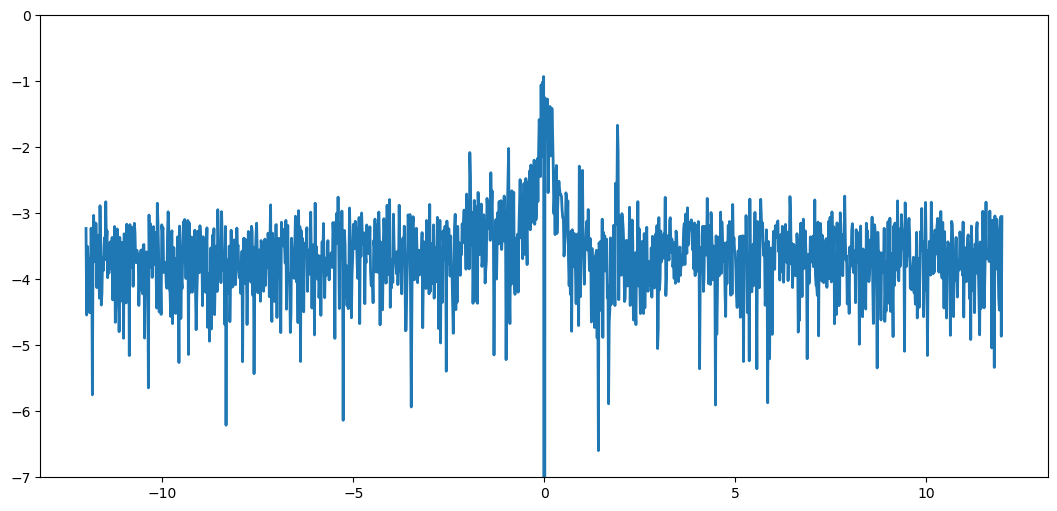

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(13, 6))
h1, = plt.plot(np.fft.fftshift(f),np.fft.fftshift(np.log10(szz[10,:])),scaley=True,linewidth=2)
ax.set_ylim([-7,-0])

In [79]:
# next is to flip frequencies for hemisphere, calculate a global average, and calculate the averages by latitude. How do we do this? split, combine, apply?
# here we ignore the depth or the drogue status: we might want to use this to further split everything.